In [1]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [2]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
import pickle

imgs, y = pickle.load(open('../CatsVDogs.p', 'rb'))

In [4]:
import numpy as np
from IPython.display import display
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
    
X_tf = np.array([img_to_array(img) for img in imgs])
X_tf = preprocess_input(X_tf)

X_tf.shape

(2000, 224, 224, 3)

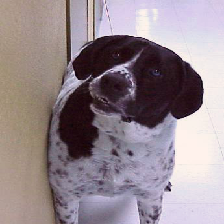

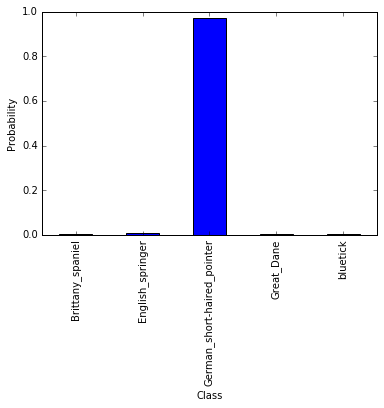

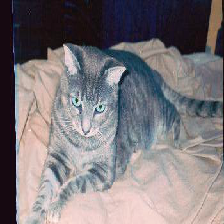

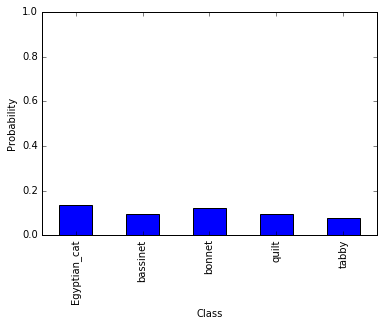

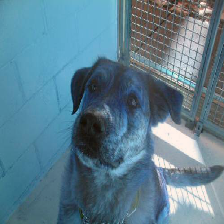

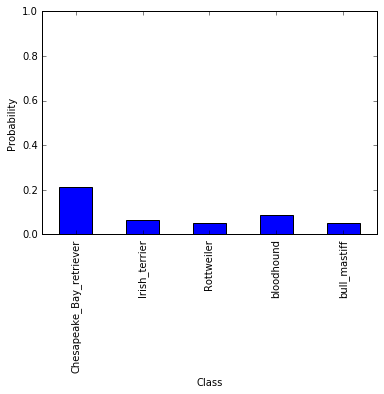

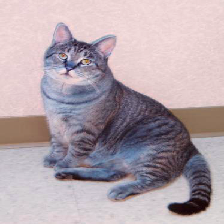

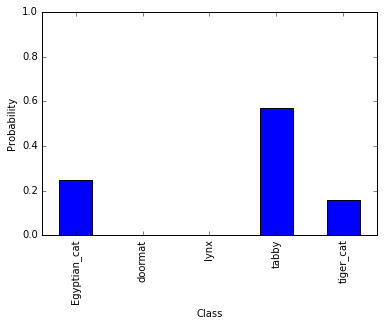

In [5]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing.image import array_to_img

y_pred = model.predict(X_tf[:4])
y_pred = decode_predictions(y_pred)

for x, probas in zip(X_tf, y_pred):
    img = array_to_img(x)
    display(img)
    
    s = pd.Series(dict((name, proba) for id, name, proba in probas))
    axes = s.plot(kind='bar')
    axes.set_xlabel('Class')
    axes.set_ylabel('Probability')
    axes.set_ylim([0, 1])
    plt.show()

In [6]:
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense

vgg16 = VGG16(weights='imagenet')

fc2 = vgg16.get_layer('fc2').output
p = Dense(output_dim=1, activation='sigmoid')(fc2)
model = Model(input=vgg16.input, output=p)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1, activation="sigmoid")`
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [8]:
for layer in model.layers[:-1]:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable:'background-color: {"white" if trainable else "lightblue"}', subset=['trainable'])

In [10]:
model.fit(X_tf, y, validation_split=0.1, nb_epoch=5)

/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


Train on 1800 samples, validate on 200 samples
Epoch 1/5
1800/1800 [==============================] - 37s - loss: 0.0389 - acc: 0.9861 - val_loss: 0.0545 - val_acc: 0.9850

In [12]:
from keras.optimizers import SGD

for layer in model.layers:
    if layer.name not in ['fc1', 'fc2', 'flatten'] and not layer.name.startswith('block5'):
        continue
    model.get_layer(layer.name).trainable = True

df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: 'background-color: {"white" if trainable else "lightblue"}', subset=['trainable'])

In [13]:
from keras.optimizers import SGD

sgd = SGD(lr=1e-4)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_tf, y, epochs=3, validation_split=0.1);

Train on 1800 samples, validate on 200 samples
Epoch 1/3
1800/1800 [==============================] - 46s - loss: 0.0043 - acc: 1.0000 - val_loss: 0.0566 - val_acc: 0.9850